## Usman Rizwan

# Enron Scandal

Enron was once the seventh largest company in America. In August 2000 Enron share prices peaked at \$90.75. However by the end of 2001 the share prices had dropped to below \$1. On December 2nd, 2001 Enron declared bankcruptcy.

Top Enron officials started dumping their shares prior to the precipitous drop in share prices. Restrictions were placed on lower-level employees that prevented them from selling their stock. Many lower-level employees lost their life savings as a result. Enron paid the top 140 executives \$680 million in 2001.

Many top-level enron employees were brought to trial and convicted. Despite large amounts of information on the internal workings of the organization released into the public domain, no smoking gun evidence was found. It is still worthwhile to investigate the enron dataset using machine learning algorithm to see if machine learning can help us find some hidden smoking gun in the data set that the human prosecutors failed to notice during the trials.

## Project Overview

In this project I will look at the financial and email data set that was made public by the Federal Energy Regulatory Commission. I will use machine learning algorithm to identify persons of interest (POI) in the data set. A POI is someone who was indicted, settled or testified in exchange for immunity.

The data analysis will follow the following steps:
    1. Clean up the data set.
    2. Look at the presence of any outliers.
    3. Try different machine learning algorithms.
    4. Tune feature selection and introduce new features.
    5. Validate the algorithm

# Important Concepts
### Variance vs Bias

Variance araises because of sensitivity to small fluctuations in the training set. It leads to over-fitting, which means that the model performs well on the training set but poorly on previously unseen data, called the testing set. 

Bias is error from erroneous assumption. It usually arises when trying to fit a complex training set with a simple model. This leads to under-fitting, which means the model doesn't perform well on the training or tesing set. There is a tradeoff between variance and bias, trying to reduce one type of error leads to an increase in the other type of error.

### Precision vs Recall

Precision and recall are defined as 
$$\text{Precision} = \frac{true-positives}{true-positives + false-positives}$$

$$\text{Recall} = \frac{true-positives}{true-positives + false-negative}$$

A high-precision in this context means that few non-POI's were falsely classified as POI's by our algorithm while a high recall means that few POI's were mistakenly classiffied as non-POI's.

## Cleaning the Data Set

In [1]:
#Load the libraries and paths needed for analysis
import sys
import pickle
import numpy as np
import pandas as pd
from math import isnan, sqrt
sys.path.append("tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier


from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import grid_search
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
##A look at all the features present in the data set
data_dict["SHERRICK JEFFREY B"].keys()

dict_keys(['director_fees', 'total_stock_value', 'deferral_payments', 'other', 'expenses', 'salary', 'deferred_income', 'exercised_stock_options', 'email_address', 'restricted_stock', 'poi', 'to_messages', 'long_term_incentive', 'loan_advances', 'from_this_person_to_poi', 'from_poi_to_this_person', 'from_messages', 'bonus', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_payments'])

In [4]:
#Read in all the features
features_list = ['poi', 'shared_receipt_with_poi', 'from_messages', 'exercised_stock_options', \
                 'from_poi_to_this_person', 'restricted_stock', 'salary', 'total_payments', 'other', \
                 'from_this_person_to_poi', 'to_messages', 'total_stock_value', 'long_term_incentive', \
                 'bonus', 'loan_advances', 'director_fees', 'expenses', 'deferral_payments', \
                 'restricted_stock_deferred', 'deferred_income']

### Store to my_dataset for easy export below.
my_dataset = data_dict
#print(my_dataset)
### Extract features and labels from dataset 
### for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
#print(data)
labels, features = targetFeatureSplit(data)

In [5]:
#Total number of people in the data set
len(my_dataset)

146

In [6]:
#Total Number of features
print(len(data_dict["SHERRICK JEFFREY B"].keys()))

21


In [7]:
#Tota Number of POI
Total_No_of_POI = 0
for key, item in data_dict.items():
    for k, i in item.items():
        if k=="poi" and i == 1:
            Total_No_of_POI += 1
print(Total_No_of_POI)

18


There are a total of 146 people in the data sets and each person is defined by 23 features. Only 18 people in the dat set are classified as POI.

Let's now see if there are any outlier values in the data set.

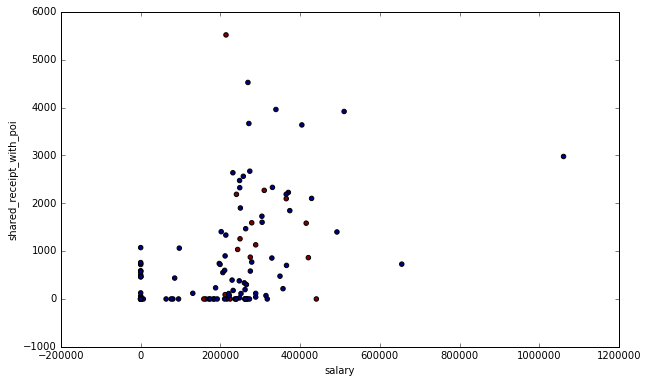

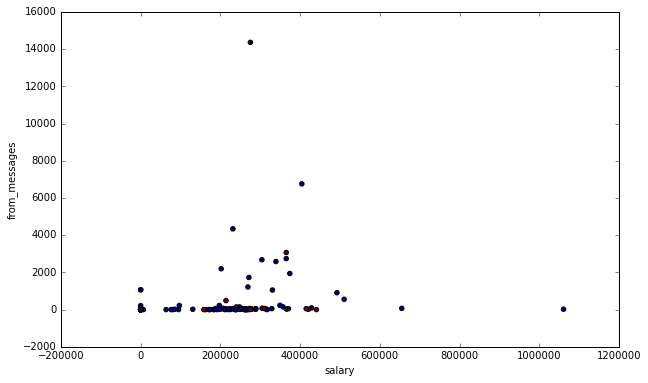

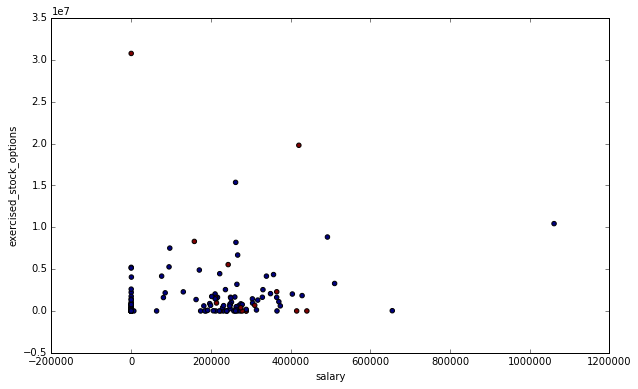

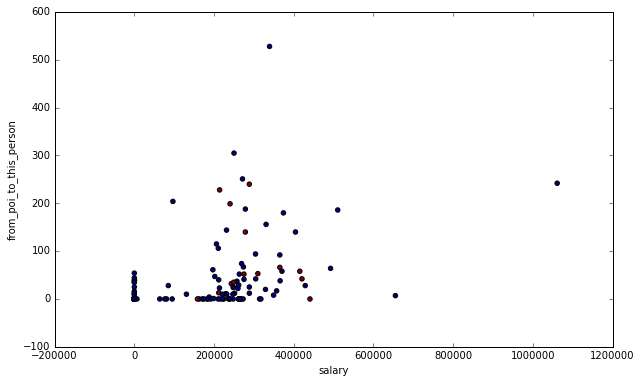

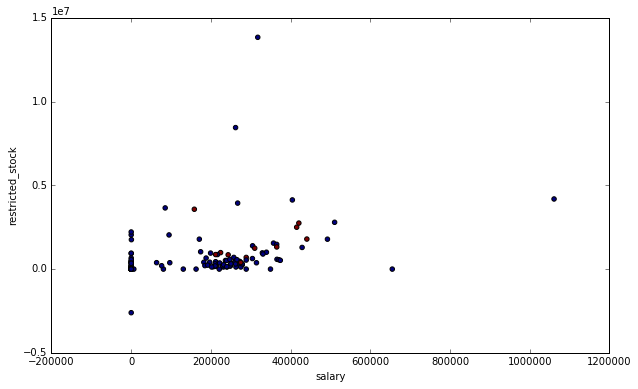

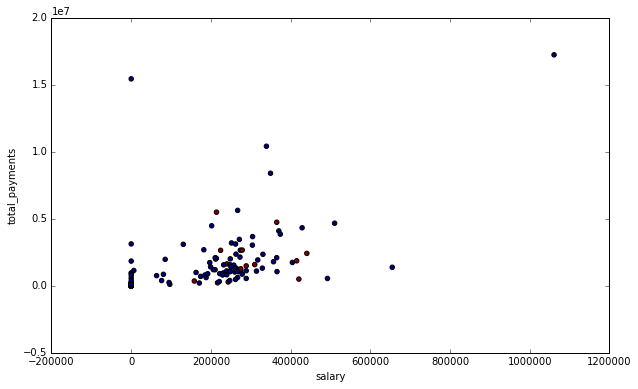

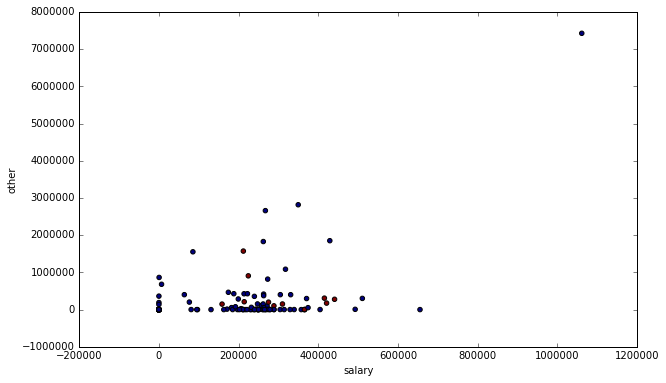

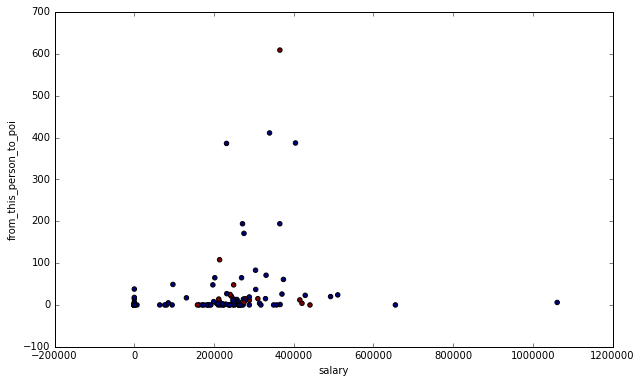

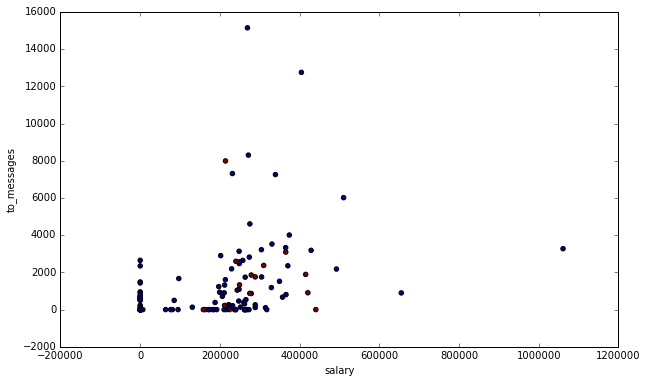

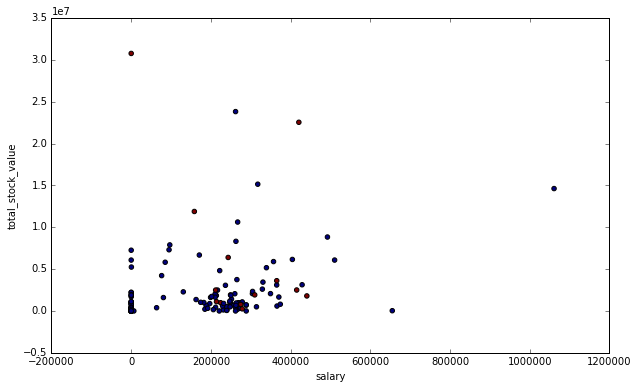

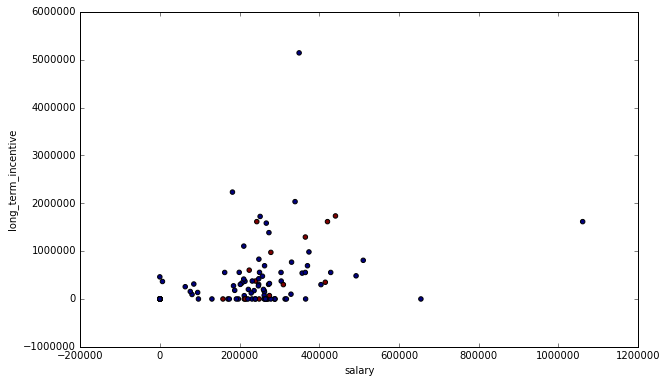

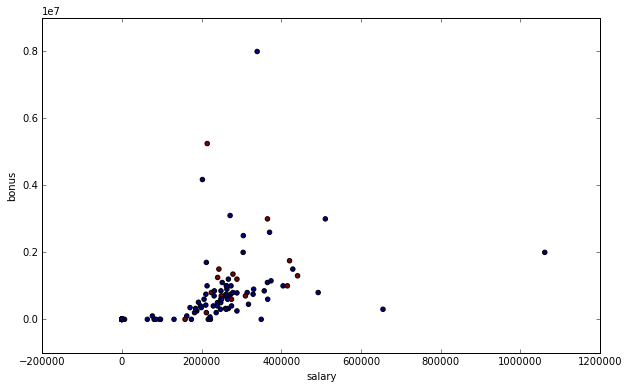

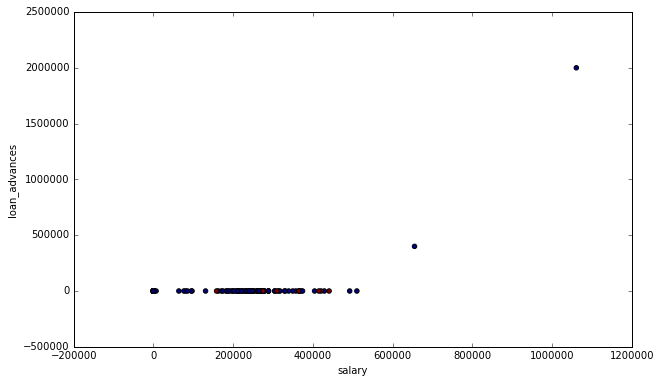

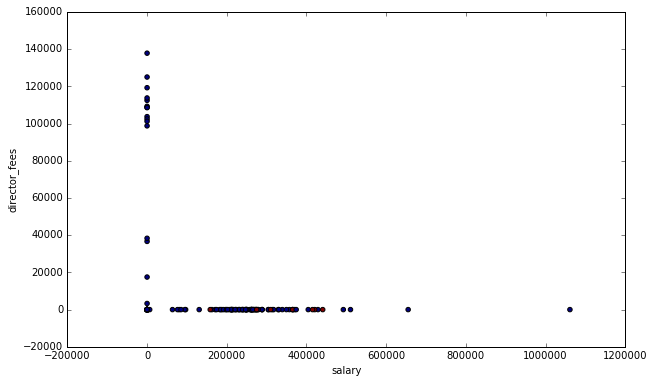

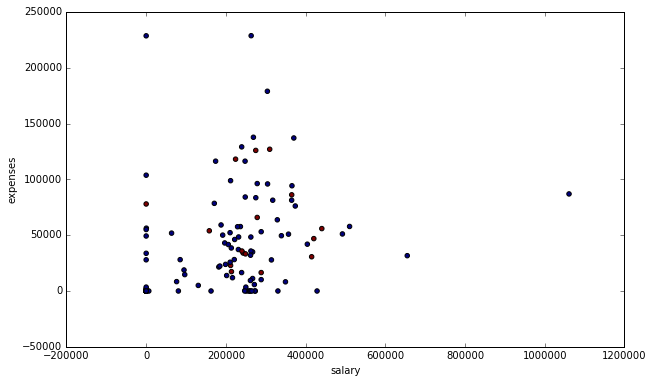

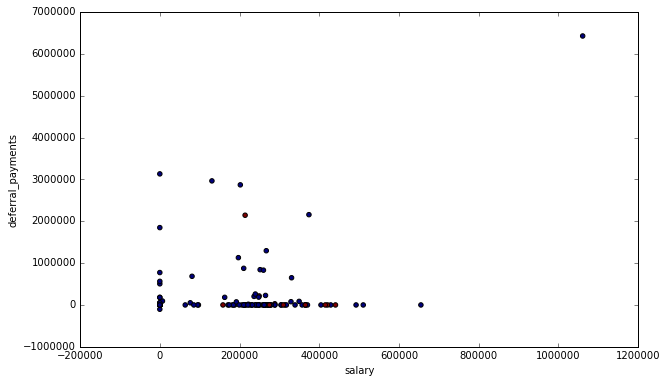

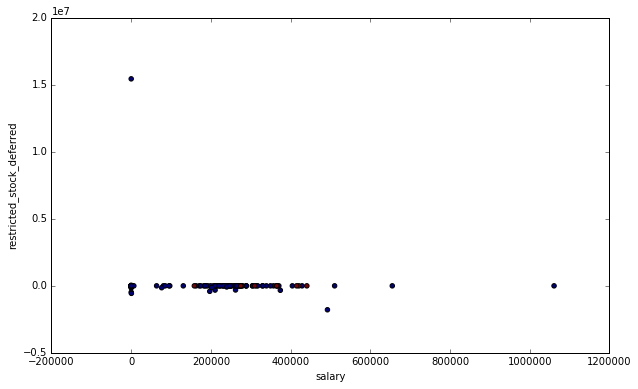

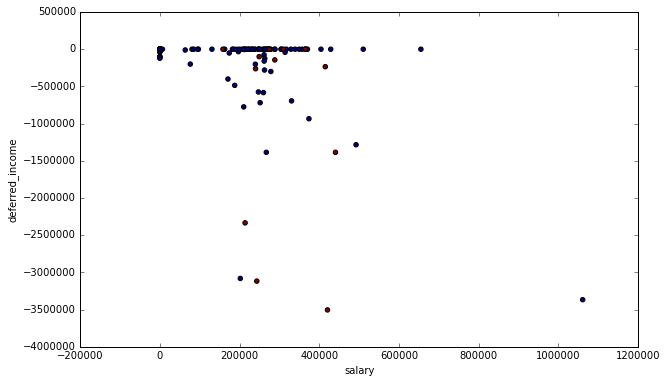

In [8]:
#Plot all features againt salray to check for outliers
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)
import numpy as np
from math import sqrt

i = 5

for j in range(len(features_list) - 1):
    if i!=j:
        plt.scatter(np.array(features)[:,i], np.array(features)[:,j], c = labels)
        plt.ylabel(features_list[j+1])
        plt.xlabel(features_list[i+1])
        plt.show()

There are 22 non-POI features in total but it seems for some features like loan advancement, deffered income, restricted and stocks defferred we have no information at all. So in the plots abve we see most of the points for these features concentrated at the y=0 line.

From the plots above we see that there are some outlier salaries, bonuses, total payments, exercised stock options and others. On further inspection it seems that these outliers are due to TOTAL key in the data set. This key contains the sum of salaries, bonuses and other known payments given out to people in the data set. This feature is useless for our purposes so we will take it out of the dictionary.

In [9]:
#Checking the TOTAL key
print(data_dict["TOTAL"])

{'director_fees': 1398517, 'total_stock_value': 434509511, 'deferral_payments': 32083396, 'other': 42667589, 'expenses': 5235198, 'salary': 26704229, 'deferred_income': -27992891, 'exercised_stock_options': 311764000, 'email_address': 'NaN', 'restricted_stock': 130322299, 'poi': False, 'to_messages': 'NaN', 'long_term_incentive': 48521928, 'loan_advances': 83925000, 'from_this_person_to_poi': 'NaN', 'from_poi_to_this_person': 'NaN', 'from_messages': 'NaN', 'bonus': 97343619, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_payments': 309886585}


In [10]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Removing the TOTAL key
my_dataset.pop("TOTAL", None)

### Extract features and labels from dataset 
### for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

Rather than working with all the data set in our machine learning algorithm we will split the data set into a traning and testing set. This is done to get an honest assesment of our predictive model. If we use the whole data set to build our predictive model and then test our predictive model on the same set, our model would just repeat the labels of the samples it was trained on. This would not give us a good way to judge how our predictive model would behave on future data.

We check the validity of our predictive model by training it on the traing set and then testing it on previously unseen testing set. This will give a much better idea about how accurate our prediction model would on data that we haven't seen yet.

In the present case we will do a 80-20 split, i.e. 80% of the total data will be used for training and 20% will be used for testing.

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                               test_size=0.20, random_state=1)

## Decision Tree Algorithm

The first algorithm we will use to build a classification model is the decision tree algorithm. Decision tree is a classification algorithm that builds a classification or regression models in the form of a tree structure. It breaks down a given set into smaller and smaller subsets while developing a decision tree incrementally. A decision tree is made up of decision nodes and leaf nodes. A decision node has two or more branches while a leaf node represents a classification (for e.g. True or False). 

In [12]:
tr = DecisionTreeClassifier(random_state=1)
tr.fit(features_train, labels_train)

pred = tr.predict(features_train)
print("accuracy :", round(accuracy_score(pred, labels_train),3))
print("precision :", round(precision_score(labels_train, pred), 3))
print("recall :", round(recall_score(labels_train, pred), 3))

accuracy : 1.0
precision : 1.0
recall : 1.0


The out of the box accuracy of the decision tree algorithm is perfect on the training set. Lets see how the model performs on the test set.

In [13]:
pred = tr.predict(features_test)
print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.897
precision : 0.0
recall : 0.0


The model does not generalize over to the test set. Precision and recall are both 0.

Now lets see if feature selection can help us improve the accuracy, precision and recall. The feature selection method we will use is the recursive feature selection. In this method a model is trained on the initial set of features and weights are assigned to features. Features whose weights are the smallest are removed from the feature set and the procedure is recursively repeated on the pruned feature set until the desired number of features to select is eventually reached. By default the algorithm selects the half of the total number of features and runs the selected algorithm on these features.

In [14]:
names = features_list[1:]

In [15]:
#rank all features, i.e continue the elimination until the last one
rfe = RFE(DecisionTreeClassifier(random_state=0))
rfe.fit(features_train, labels_train)
pred = rfe.predict(features_train)

zig = 1
print ("Features used in the decision tree algorithm:")
for i in range(len(rfe.ranking_)):
    if rfe.ranking_[i] == 1:
        print("\t", zig, ".",  names[i])
        zig+=1

print("accuracy :", round(accuracy_score(pred, labels_train),3))
print("precision :", round(precision_score(labels_train, pred), 3))
print("recall :", round(recall_score(labels_train, pred), 3))

Features used in the decision tree algorithm:
	 1 . from_messages
	 2 . restricted_stock
	 3 . from_this_person_to_poi
	 4 . bonus
	 5 . director_fees
	 6 . expenses
	 7 . deferral_payments
	 8 . restricted_stock_deferred
	 9 . deferred_income
accuracy : 1.0
precision : 1.0
recall : 1.0


The method selects 9 most important features and performs the fit on those features. It works perfectly on the training set. Let's see how it performs on the test set.

In [16]:
rfe = RFE(DecisionTreeClassifier(random_state=0))
rfe.fit(features_train, labels_train)
pred = rfe.predict(features_test)


print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.897
precision : 0.0
recall : 0.0


Again the model does not generalize well over to the test set. Its accuracy, precision and recall are still 0. It seems that the model overfits on the training set and doesn't generalize at all to the test set. To work around this problem we will use K-fold cross-validation.

In K-fold cross-validation training data is split into K folds of equal size. Each K fold acts as the test set once and as the training set K-1 times. The advantage of K-Fold Cross validation is that all the examples in the training dataset are used for both training and testing. It provides us with a predictive model that has lower variance. This is particularly useful when we are dealing awith a small data set and our classes are skewed (most of the people in the dataset are not POI). There is actually a lot of variation in the performance of our algorithms depending on the partition of the data. Cross-validation helps reduce this variation by making the predictive model less sensitive to the partitioning of the data.

In this case we will 10-fold cross validation and use precision instead of accuracy to measure the performance of the algorithm. This is because we are dealing with a skewed data set, so precision is a better measure of perfrmance than accuracy.

Optimal number of features : 3


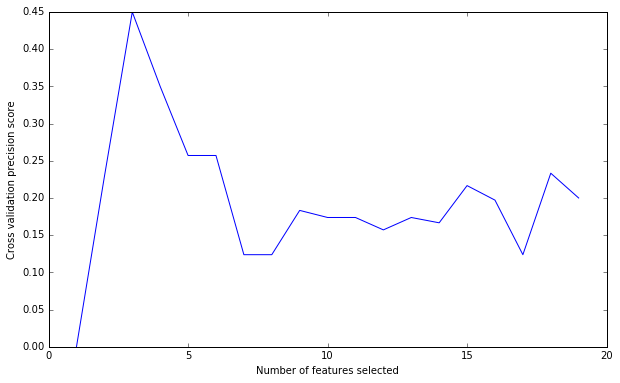

In [17]:
rfecv = RFECV(estimator=DecisionTreeClassifier(random_state=0), step=1, cv=5, scoring='precision')
    
rfecv.fit(features_train, labels_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation precision score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [18]:
zig = 1
print ("Features used in the decision tree algorithm:")
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        print("\t", zig, ".",  names[i])
        zig+=1

Features used in the decision tree algorithm:
	 1 . bonus
	 2 . expenses
	 3 . deferred_income


In [19]:
pred = rfecv.predict(features_test)

print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.828
precision : 0.0
recall : 0.0


There is no improvement in the performance of algorithm. It should be noted here that we are using the decision tree algorithm as it comes out of the box. We haven't optimized any of the parameters of the decision tree algorith. So lets use the grid search method to optimize the decision tree algorithm on the whole data set first. The parameters that will be optimized are criterion (function to measure the quality of a split), min_samples_split (minimum number of samples required to split an internal node), max_features (the number of features to consider when looking for the best split at a node) and max_depth (the maximum depth of the tree).

In [20]:
etc = DecisionTreeClassifier()

results = {}

param_grid = {"random_state": [1], 'criterion':['gini',"entropy"], \
             'min_samples_split': [10,20,30], "max_features": ["auto", "sqrt", "log2"], \
             'max_depth': [10,15,20]}

dtr = grid_search.GridSearchCV(etc, param_grid, scoring="precision")
dtr.fit(features_train, labels_train)

print(dtr.best_params_)

{'min_samples_split': 10, 'max_features': 'auto', 'random_state': 1, 'max_depth': 10, 'criterion': 'gini'}


In [21]:
rfe = RFE(dtr.best_estimator_)
rfe.fit(features_train, labels_train)
pred = rfe.predict(features_train)

zig = 1
print ("Features used in the decision tree algorithm:")
for i in range(len(rfe.ranking_)):
    if rfe.ranking_[i] == 1:
        print("\t", zig, ".",  names[i])
        zig+=1

print("accuracy :", round(accuracy_score(pred, labels_train),3))
print("precision :", round(precision_score(labels_train, pred), 3))
print("recall :", round(recall_score(labels_train, pred), 3))

Features used in the decision tree algorithm:
	 1 . other
	 2 . from_this_person_to_poi
	 3 . long_term_incentive
	 4 . bonus
	 5 . director_fees
	 6 . expenses
	 7 . deferral_payments
	 8 . restricted_stock_deferred
	 9 . deferred_income
accuracy : 0.92
precision : 0.833
recall : 0.385


In [22]:
pred = rfe.predict(features_test)

print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.862
precision : 0.0
recall : 0.0


There is no improvement in the performance of our algorithm. Both precision and accuracy have still 0. Let us see if K-fold cross validation helps further improve the performance of the algorithm.

Optimal number of features : 6


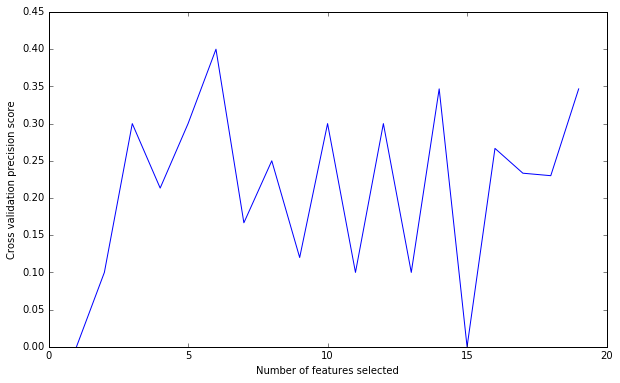

In [23]:
rfecv = RFECV(estimator=dtr.best_estimator_, step=1, cv=5, scoring='precision')
    
rfecv.fit(features_train, labels_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation precision score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [24]:
op_features_list = ["poi"]
zig = 1
print ("Features used in the decision tree algorithm:")
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        op_features_list.append(str(names[i]))
        print("\t", zig, ".",  names[i])
        zig+=1

pred = rfecv.predict(features_train)
print("accuracy :", round(accuracy_score(pred, labels_train),3))
print("precision :", round(precision_score(labels_train, pred), 3))
print("recall :", round(recall_score(labels_train, pred), 3))

Features used in the decision tree algorithm:
	 1 . from_this_person_to_poi
	 2 . long_term_incentive
	 3 . bonus
	 4 . expenses
	 5 . restricted_stock_deferred
	 6 . deferred_income
accuracy : 0.947
precision : 0.889
recall : 0.615


In [25]:
pred = rfecv.predict(features_test)
print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.862
precision : 0.0
recall : 0.0


Again we see no improvement in the performance of our algorithm. The precision and recall have both increased.

Now, let us try and add some features to our feature set. Reading about the background of the Enron scandal and trials it seems that prosecutors noticed that some of the Enron officials weren't big e-mail users while others used it excessively. If people weren't big e-mail users than it is likely people didn't sent them that many e-mails either. It is reasonable to normalize the amount of emails reieved from POI to the total number of e-mails recieved and similarly it is reasonable to normalize the amount of e-mails sent to POI to the total numbers of e-mails sent.

In [26]:
for key, value in my_dataset.items():
    if value["from_messages"] != 0:
        value["to_poi_ratio"] = float(value['from_this_person_to_poi'])/float(value["from_messages"])
        if isnan(value["to_poi_ratio"]):
            value["to_poi_ratio"] = "NaN"
    else:
        value["to_poi_ratio"] = "NaN"
        
    if value["to_messages"] != 0:
        value["from_poi_ratio"] = float(value['from_poi_to_this_person'])/float(value["to_messages"])
        if isnan(value["from_poi_ratio"]):
            value["from_poi_ratio"] = "NaN"
    else:
        value["from_poi_ratio"] = "NaN"

In [27]:
#Lets add the new features to our features list
new_features_list = ['poi', 'shared_receipt_with_poi', 'from_messages', 'exercised_stock_options', \
                 'from_poi_to_this_person', 'restricted_stock', 'salary', 'total_payments', 'other', \
                 'from_this_person_to_poi', 'to_messages', 'total_stock_value', 'long_term_incentive', \
                 'bonus', 'loan_advances', 'director_fees', 'expenses', 'deferral_payments', \
                 'restricted_stock_deferred', 'deferred_income', 'from_poi_ratio', 'to_poi_ratio']


new_data = featureFormat(my_dataset, new_features_list, sort_keys = True)

new_labels, new_features = targetFeatureSplit(new_data)

In [28]:
new_names = new_features_list[1:]

In [29]:
new_features_train, new_features_test, new_labels_train, new_labels_test = train_test_split(
    new_features, new_labels, test_size=0.20, random_state=1)

In [30]:
etc = DecisionTreeClassifier()

results = {}

param_grid = {"random_state": [0], 'criterion':["entropy"], \
             'min_samples_split': [10,20,30], "max_features": ["auto", "sqrt", "log2"], \
             'max_depth': [10,15,20]}

dtr = grid_search.GridSearchCV(etc, param_grid, scoring = "recall", cv=5)
dtr.fit(new_features_train, new_labels_train)


print(dtr.best_params_)

{'min_samples_split': 10, 'max_features': 'auto', 'random_state': 0, 'max_depth': 10, 'criterion': 'entropy'}


Optimal number of features : 9


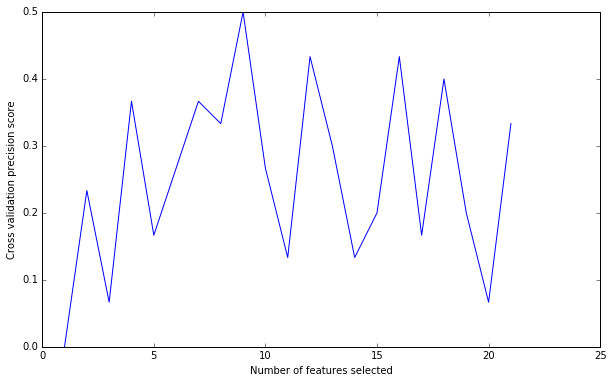

In [31]:
rfecv = RFECV(estimator=dtr.best_estimator_, step=1, cv=5, scoring='recall')
    
rfecv.fit(new_features_train, new_labels_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation precision score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [32]:
op_features_list = ["poi"]
zig = 1
print ("Features used in the decision tree algorithm:")
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        op_features_list.append(str(new_names[i]))
        print("\t", zig, ".",  new_names[i])
        zig+=1

pred = rfecv.predict(new_features_train)
print("accuracy :", round(accuracy_score(pred, new_labels_train),3))
print("precision :", round(precision_score(new_labels_train, pred), 3))
print("recall :", round(recall_score(new_labels_train, pred), 3))

Features used in the decision tree algorithm:
	 1 . salary
	 2 . loan_advances
	 3 . director_fees
	 4 . expenses
	 5 . deferral_payments
	 6 . restricted_stock_deferred
	 7 . deferred_income
	 8 . from_poi_ratio
	 9 . to_poi_ratio
accuracy : 0.965
precision : 0.8
recall : 0.923


In [33]:
pred = rfecv.predict(new_features_test)
print("accuracy :", round(accuracy_score(pred, new_labels_test),3))
print("precision :", round(precision_score(new_labels_test, pred), 3))
print("recall :", round(recall_score(new_labels_test, pred), 3))

accuracy : 0.793
precision : 0.0
recall : 0.0


With the addition of the new features into our feature set there is still no improvement in the performance of the algorithm on the test set. Let us try another algorithm to see if we can reach better results.

## K Nearest Neighbour algorithm

Let us now move onto another machine learning algorithm, the K Nearest Neighbour algorithm. I will try to use 1 to 20 nearest neighbours to classify a point to see if larger or fewer neighbours help improve the algorithm. As previously I will use precision to decide what number of neighbours performs best.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1, 21)
precision_ser = []

for i in k_range:
    neighb = KNeighborsClassifier(n_neighbors = i)
    neighb.fit(features_train, labels_train)
    pred = neighb.predict(features_train)
    precision_ser.append(precision_score(labels_train, pred))

(0, 1.1)

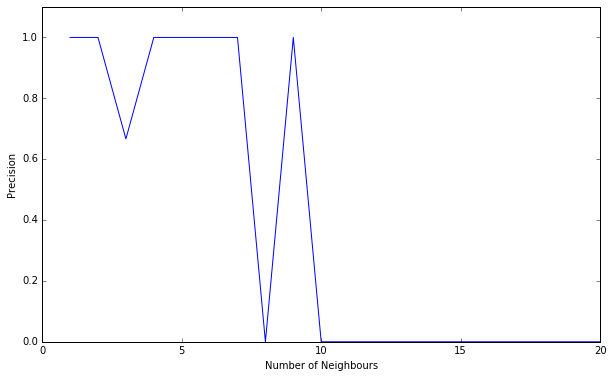

In [35]:
plt.plot(k_range, precision_ser)
plt.xlabel("Number of Neighbours")
plt.ylabel("Precision")
plt.ylim((0,1.1))

The maximum precision occurs at 1, 2, 4, 5, 6, 7 and 9. There is a bias-variance trade-off involved here, small values of K will produce a model with low bias and high variance while large values of K will produce a model with high bias and low variance. So we will go towards the middle and pick the best K as 6.

In [36]:
neighb = KNeighborsClassifier(n_neighbors = 6)
neighb.fit(features_train, labels_train)
pred = neighb.predict(features_test)
print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.897
precision : 0.0
recall : 0.0


As seen from the results above the model doesn't generalize over to the test set. Let us now try the K-fold cross-validation method to find the best number of neighbors for classification.

In [37]:
from sklearn.cross_validation import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 3)
prec_scores = cross_val_score(knn, features_train, labels_train, cv = 5, scoring="precision")
print(prec_scores)
print(prec_scores.mean())

[ 1.   0.   0.5  0.   0. ]
0.3


From the method above we get an array of precisions with an average of 0.3. Now, to get the optimum number of nearest neighbours we will loop over a reasonable number of K nearest neighbors and choose the K that gives the average precision.

In [38]:
precision_ser = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors = i)
    prec_scores = cross_val_score(knn, features_train, labels_train, cv = 5, scoring="precision")
    precision_ser.append(prec_scores.mean())

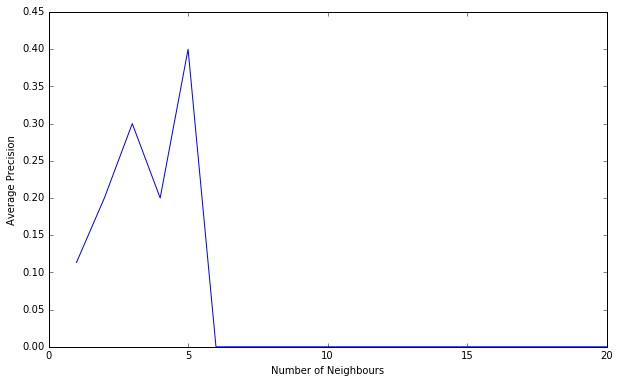

In [39]:
plt.plot(k_range, precision_ser)
plt.xlabel("Number of Neighbours")
plt.ylabel("Average Precision")

According to the cross-validation method, 5 is the best nearest neighbor parameter for the K-NN algorithm. Let us try the K-NN algorithm with 5 nearest neighbor on the test set.

In [40]:
neighb = KNeighborsClassifier(n_neighbors = 5)
neighb.fit(features_train, labels_train)
pred = neighb.predict(features_test)
print("accuracy :", round(accuracy_score(pred, labels_test),3))
print("precision :", round(precision_score(labels_test, pred), 3))
print("recall :", round(recall_score(labels_test, pred), 3))

accuracy : 0.862
precision : 0.0
recall : 0.0


In [41]:
precision_ser = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors = i)
    prec_scores = cross_val_score(knn, new_features_train, new_labels_train, cv = 5, scoring="precision")
    precision_ser.append(prec_scores.mean())

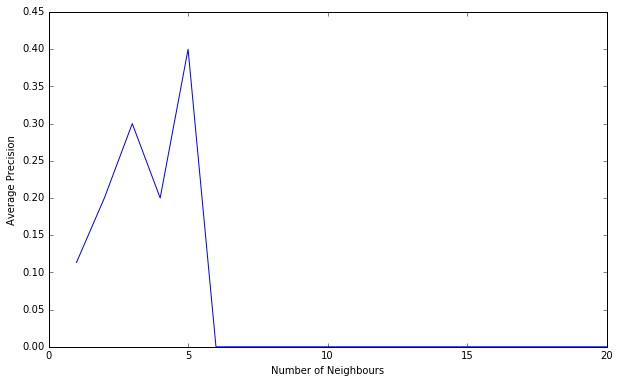

In [42]:
plt.plot(k_range, precision_ser)
plt.xlabel("Number of Neighbours")
plt.ylabel("Average Precision")

In [43]:
neighb_best = KNeighborsClassifier(n_neighbors = 5)
neighb_best.fit(new_features_train, new_labels_train)
pred = neighb_best.predict(new_features_test)
print("accuracy :", round(accuracy_score(pred, new_labels_test),3))
print("precision :", round(precision_score(new_labels_test, pred), 3))
print("recall :", round(recall_score(new_labels_test, pred), 3))

accuracy : 0.862
precision : 0.0
recall : 0.0


The algorithm still doesn't generalize from the training set to the testing set. It should be noted that we haven't scaled the data. In K-NN it is important to scale the data because you want the distances to be meaningful. In our case the number of e-mail recieved can be between 0 and 15000 while stock values are between 0 and 31 million. For the distances between the points evaluated in the K-NN algorithm to be meaningful it is important to scale the features. We will use scale function from sklearn to scale all the data point to between -10 and 10.

In [44]:
from sklearn import preprocessing

X_train = new_features_train
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-10, 10))
X_train_minmax = min_max_scaler.fit_transform(X_train)

In [45]:
precision_ser = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors = i)
    prec_scores = cross_val_score(knn, X_train_minmax, labels_train, cv = 5, scoring="precision")
    precision_ser.append(prec_scores.mean())

(0, 0.25)

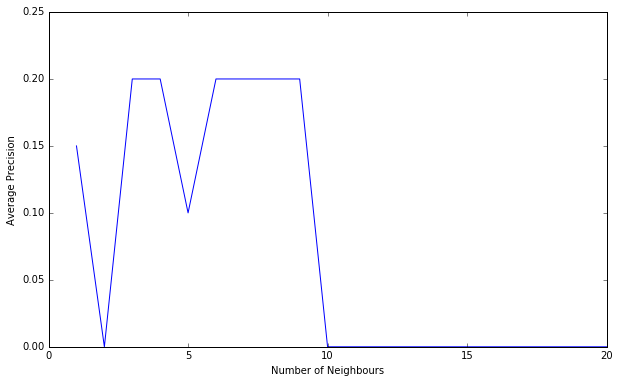

In [46]:
plt.plot(k_range, precision_ser)
plt.xlabel("Number of Neighbours")
plt.ylabel("Average Precision")
plt.ylim((0,0.25))

In [47]:
X_test = new_features_test
X_test_minmax = min_max_scaler.transform(X_test)

In [48]:
neighb = KNeighborsClassifier(n_neighbors = 9)
neighb.fit(X_train_minmax, new_labels_train)
pred = neighb.predict(X_test_minmax)
print("accuracy :", round(accuracy_score(pred, new_labels_test),3))
print("precision :", round(precision_score(new_labels_test, pred), 3))
print("recall :", round(recall_score(new_labels_test, pred), 3))

accuracy : 0.862
precision : 0.0
recall : 0.0


Let's do some variance threshold feature selection to remove features that do not have a lot of variation. We will try a couple of variance threshold to see which one gives the best performance in terms of precision on the training set.

In [49]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold()
X_train_var = sel.fit_transform(X_train_minmax)

print(sel.variances_)

[ 16.35906252   5.08297533   8.62892177   8.37449842   4.27359683
  21.69637569   7.77173128  11.55714011   8.52094775  10.23596354
  10.70993163   6.53001348   7.74598017   3.50849714  21.89650631
  17.68951503  13.79668943   2.88083498  11.86150754  11.46456337
  14.36238792]


As seen above, the variance of the scaled features varies between 2.88 and 21.9. Let's do some feature selection.

In [50]:
from sklearn.feature_selection import VarianceThreshold
X = X_train_minmax

data = {}
thresholds = np.arange(3, 21, 2)


for i in thresholds:
    sel = VarianceThreshold(threshold=i)
    X_train_var = sel.fit_transform(X)
    data[i] = []
    for j in k_range:
        knn = KNeighborsClassifier(n_neighbors = j)
        prec_scores = cross_val_score(knn, X_train_var, new_labels_train, cv = 5, scoring="precision")
        data[i].append([j, prec_scores.mean()])

(0, 0.6)

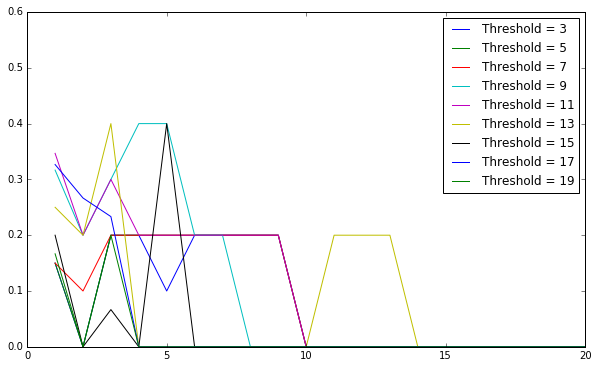

In [51]:
for i in thresholds:
    X = data[i]
    plt.plot(np.array(X)[:,0], np.array(X)[:,1], label="Threshold = " + str(i))
    plt.legend()
plt.ylim((0,0.6))

We get the best precision when threshold is 15 and the value of parameter k is 5. Let's use these parameters to see how well the algorithm performs on the test set.

In [52]:
sel = VarianceThreshold(threshold=15)
X_train_var = sel.fit_transform(X_train_minmax)
X_test_var = sel.transform(X_test_minmax)

zig = 1
print ("Features used in the K-NN algorithm:")
for i in range(len(sel.variances_)):
    if sel.variances_[i] > 15:
        print("\t", zig, ". ", new_names[i])
        zig+=1

neighb_var = KNeighborsClassifier(n_neighbors = 5)
neighb_var.fit(X_train_var, new_labels_train)
pred = neighb_var.predict(X_test_var)
print("accuracy :", round(accuracy_score(pred, new_labels_test),3))
print("precision :", round(precision_score(new_labels_test, pred), 3))
print("recall :", round(recall_score(new_labels_test, pred), 3))

Features used in the K-NN algorithm:
	 1 .  shared_receipt_with_poi
	 2 .  salary
	 3 .  director_fees
	 4 .  expenses
accuracy : 0.897
precision : 0.0
recall : 0.0


The performance of the algorithm is not improved at all. It seems feature selection reduces the number of features and overfits the data which leads to high variance. Therefore the algorithm does not perform well on the test set.

## Manual Feature Selection

Both threshold feature selection and recursive feature selection have failed to improve the performances of either the K-NN or decision tree algorithms. It is now time to attempt some manual feature selection. The algorithms attempted in the previous sections provide a general idea of what the most important features are to classify POI's. After a bit of trial and error I have decided on the following 8 features, not including POI.

In [53]:
op_features_list = ['poi',
 'other',
 'long_term_incentive',
 'expenses',
 'deferral_payments',
 'restricted_stock_deferred',
 'deferred_income',
 'from_poi_ratio',
 'to_poi_ratio']
len(op_features_list)

9

In [54]:
#Lets add the new features to our features list
op_data = featureFormat(my_dataset, op_features_list, sort_keys = True)

op_labels, op_features = targetFeatureSplit(op_data)

In [55]:
op_features_train, op_features_test, op_labels_train, op_labels_test = train_test_split(
    op_features, op_labels, test_size=0.20, random_state=1)

In [56]:
len(op_features_train[0])

8

In [57]:
etc = DecisionTreeClassifier()

results = {}

param_grid = {"random_state": [1], 'criterion':["entropy", "gini"], \
             'min_samples_split': [10,20,30,50], "max_features": ["auto", "sqrt", "log2"], \
             'max_depth': [10,20,30,50]}

dtr = grid_search.GridSearchCV(etc, param_grid, scoring = "precision", cv=5)
dtr.fit(op_features_train, op_labels_train)


print(dtr.best_params_)

{'min_samples_split': 10, 'max_features': 'auto', 'random_state': 1, 'max_depth': 10, 'criterion': 'entropy'}


In [58]:
tr = dtr.best_estimator_
tr.fit(op_features_train, op_labels_train)

pred = tr.predict(op_features_train)
print("accuracy :", round(accuracy_score(pred, op_labels_train),3))
print("precision :", round(precision_score(op_labels_train, pred), 3))
print("recall :", round(recall_score(op_labels_train, pred), 3))

accuracy : 0.953
precision : 0.875
recall : 0.636


In [59]:
pred = tr.predict(op_features_test)
print("accuracy :", round(accuracy_score(pred, op_labels_test),3))
print("precision :", round(precision_score(op_labels_test, pred), 3))
print("recall :", round(recall_score(op_labels_test, pred), 3))

accuracy : 0.852
precision : 0.6
recall : 0.6


With some manual feature selection the decision tree algorithm performs reasonable well on the test set. A precision and recall of 0.6 means that if our algorithm correctly identifies 10 POI's correctly then it would also falsely identify 6-7 people falsely as POI's and similarly 6-7 actual POI's would be classified as non-POI's.

In [60]:
dump_classifier_and_data(tr, my_dataset, op_features_list)

## Conclusion

Two algorithms were tested on the data to see which algorithm performs better. Decision tree performed incredibly well right out-of-the-box on the training set but it's success didn't translate over into the testing set. Decision trees very much overfit the data and even recursive feature selection and K-fold cross-validation were not able to improve its performance. K-NN don't perform as well on the training set. Recursive feature elimination does not work with the K-NN algorithm because it is not possible to assign weights to features in the K-NN algorithm. Even with variance threshold feature selection and cross validation the performance of the K-NN algorithm did not improve. It seems that the data set is to sparse for the application of K-NN algorithm. The variance of features varies quite considerably, K-NN is not suited for this kind of data.

It was a bit of a surprise that the recursive feature selection and variance threshold feature selection were not able to pick the best features that generalized well over to the test set. Manual feature selection with optimized decision tree parameters was able to give much better results in the end. 

The performance of the algorithm can still be improved by digging into the contents of the e-mails of the people present in the data set. The e-mails from POI to POI might have certain types of vocabulary which would set them apart from e-mails between POI and non-POI, and non-POI and non-POI.